In [1]:
import math
from concurrent.futures import ThreadPoolExecutor

import boto3
import h5py
import numpy as np
import pandas as pd
from botocore import UNSIGNED
from botocore.client import Config
from tqdm.notebook import tqdm


In [2]:
skip_pull = True  # if true, will attempt to load file path below, otherwise, will download each state and save
resstock_data_path = "D:/DATA/resstock/resstock_GA_VT.h4"
# resstock_data_path = "C:/users/szvsw/downloads/resstock_usa.h4"  # h4 is the same just fun to switch it up
# resstock_output_path = "C:/users/szvsw/downloads/resstock_usa.h5"


In [3]:
states = [
    # "AK",
    # "AL",
    # "AR",
    # "AZ",
    # "CA",
    # "CO",
    # "CT",
    # "DC",
    # "DE",
    # "FL",
    "GA",
    # "HI",
    # "IA",
    # "ID",
    # "IL",
    # "IN",
    # "KS",
    # "KY",
    # "LA",
    # "MA",
    # "MD",
    # "ME",
    # "MI",
    # "MN",
    # "MO",
    # "MS",
    # "MT",
    # "NC",
    # "ND",
    # "NE",
    # "NH",
    # "NJ",
    # "NM",
    # "NV",
    # "NY",
    # "OH",
    # "OK",
    # "OR",
    # "PA",
    # "RI",
    # "SC",
    # "SD",
    # "TN",
    # "TX",
    # "UT",
    # "VA",
    "VT",
    # "WA",
    # "WI",
    # "WV",
    # "WY",
]


In [4]:
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
b = "oedi-data-lake"


def get_state_df(state):
    try:
        k = f"nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/metadata_and_annual_results/by_state/state={state}/csv/{state}_baseline_metadata_and_annual_results.csv"
        r = s3.get_object(Bucket=b, Key=k)
        df = pd.read_csv(r["Body"])
        return df
    except Exception as e:
        print(e)
        return None


if skip_pull:
    resstock_df = pd.read_hdf(resstock_data_path, key="resstock")
else:
    resstock_dfs = {}

    with ThreadPoolExecutor(max_workers=10) as e:
        dfs = list(tqdm(e.map(get_state_df, states), total=len(states)))
        for state, df in zip(states, dfs):
            resstock_dfs[state] = df
    print(len(resstock_dfs))

    resstock_df = pd.concat(resstock_dfs.values())
    resstock_df.to_hdf(resstock_data_path, key="resstock", mode="w")

new_col_names = []
for x in resstock_df.columns:
    y = x.split(".")
    y = (y[0], ".".join(y[1:]))
    new_col_names.append(y)
resstock_df.columns = pd.MultiIndex.from_tuples(new_col_names)
resstock_df.reset_index(drop=True, inplace=True)
print(resstock_df.shape)


(18472, 260)


## Definitions for lookups

In [8]:
EPD_BASELINE = 5.38  # Reference buildings apartment
LPD_BASELINE = 3.88  # Reference buildings apartment
ACH50_ACHNAT = 14.8  # LBL average for normal conditions
SQFT_M2 = 0.092903
F2F_HEIGHT = 3
RVAL_RSI = 1 / 5.678
PERIM_DEPTH = 3

VentilationPerArea = 0
VentilationPerPerson = 0
VentilationMode = 0
EconomizerSettings = 0
RecoverySettings = 0
RoofMass = 2

hvac_cooling_type = {"Central AC": 1, "None": 0, "Heat Pump": 3, "Room AC": 1}

heating_fuel = {
    "Electricity": 1,
    "Natural Gas": 0.85,
    "Propane": 0.8,
    "Other Fuel": 1,
    "Fuel Oil": 0.8,
    "None": 0,
}

lighting = {"100% CFL": 0.26, "100% LED": 0.22, "100% Incandescent": 1}


def get_people_density(x):
    (occupants, sqft) = x
    if type(occupants) == str and "+" in occupants:
        occupants = 10
    occupants = int(occupants)
    return occupants / (SQFT_M2 * sqft)


def get_infiltration(x):
    (ach50, sqft, floors) = x
    area = SQFT_M2 * sqft
    volume = area * F2F_HEIGHT
    surface_area = area + math.sqrt(area) * 4 * F2F_HEIGHT * int(floors)
    return (
        float(ach50.split(" ACH50")[0])
        / ACH50_ACHNAT
        * volume
        / 3.6
        / surface_area
        / 1000
    )


wall_thermal_mass_constructions = {
    "Brick": 0,
    "Wood Stud": 2,
    "CMU": 1,
}

roof_thermal_mass_constructions = {
    "Asphalt Shingles, Medium": 3,
    "Composition Shingles": 3,
    "Wood Shingles": 2,
    "Metal, Dark": 3,
    "Slate": 2,
    "Tile, Clay or Ceramic": 2,
    "Tile, Concrete": 0,
}


def get_wall_insulation(x):
    if "Uninsulated" in x:
        return 0.5
    else:
        return int(x.split("R-")[-1]) * RVAL_RSI


def get_slab_insulation(all_x):
    r_tot = [0]
    for x in all_x:
        if "None" in x:
            pass
        elif "Uninsulated" in x:
            r_tot.append(0.5)
        elif "R-" in x:
            x = x.split(",")
            x = [i for i in x if "R" in i]
            x = x[0]
            r_tot.append(int(x.split("R-")[-1]) * RVAL_RSI)
        else:
            x = x.split(" ")
            x = [i for i in x if "R" in i]
            x = x[0]
            r_tot.append(int(x.split("R")[-1]) * RVAL_RSI)
    return sum(r_tot) * RVAL_RSI


# From https://www.nrel.gov/docs/fy18osti/68670.pdf
windows_uval = {
    "Double, Clear, Metal, Air": 0.76 * 5.678,
    "Double, Clear, Metal, Air, Exterior Clear Storm": 0.38 * 5.678,
    "Double, Clear, Non-metal, Air": 0.49 * 5.678,
    "Double, Clear, Non-metal, Air, Exterior Clear Storm": 0.29 * 5.678,
    "Double, Low-E, Non-metal, Air, M-Gain": 0.29 * 5.678,  # assumed
    "Single, Clear, Metal": 1.16 * 5.678,
    "Single, Clear, Metal, Exterior Clear Storm": 0.69 * 5.678,
    "Single, Clear, Non-metal": 0.84 * 5.678,
    "Single, Clear, Non-metal, Exterior Clear Storm": 0.4 * 5.678,
    "Triple, Low-E, Non-metal, Air, L-Gain": 0.4 * 5.678,
}

windows_shgc = {
    "Double, Clear, Metal, Air": 0.67,
    "Double, Clear, Metal, Air, Exterior Clear Storm": 0.51,
    "Double, Clear, Non-metal, Air": 0.56,
    "Double, Clear, Non-metal, Air, Exterior Clear Storm": 0.42,
    "Double, Low-E, Non-metal, Air, M-Gain": 0.52,  # assumed
    "Single, Clear, Metal": 0.76,
    "Single, Clear, Metal, Exterior Clear Storm": 0.59,
    "Single, Clear, Non-metal": 0.63,
    "Single, Clear, Non-metal, Exterior Clear Storm": 0.51,
    "Triple, Low-E, Non-metal, Air, L-Gain": 0.51,
}


def get_perim2core(x):
    a = x / 10.7
    x = math.sqrt(a)
    core_area = (x - 2 * PERIM_DEPTH) ** 2
    perim_area = a - core_area
    return core_area / perim_area


def get_core_depth(x, perim_depth=PERIM_DEPTH):
    core_area_to_perim_area = get_perim2core(x)
    return core_area_to_perim_area * perim_depth


def get_orientation(x):
    if x not in ["North" "East" "South" "West"]:
        return math.pi / 4
    else:
        return 0


def get_roof2floor(x):
    r2f = 0
    if x[0] != "Middle" and x[1] != "Middle":
        r2f = 1
    elif x[2] != "None":
        r2f = 0.5
    return r2f


def get_ground2floor(x):
    if x == "Middle" or x == "Top":
        return 0
    if x == "Bottom":
        return 1
    # if x[1] == "Slab":
    #     return 1
    # if x[1] == "Heated Basement" or x[1] == "Ambient":
    #     return 0
    else:
        return 1


def get_shading_height(x):
    """
    Gets shading angle given x distance away, and assumed similar height of adjascent building
    """
    (dist, floors) = x
    if dist == "None":
        return 0
    elif "ft" in dist:
        dist = 15
    else:
        dist = int(dist)

    height = F2F_HEIGHT * floors
    return math.atan(height / dist)


## Space definition

In [115]:
print(
    resstock_df[
        resstock_df[("in", "geometry_attic_type")]
        == "Finished Attic or Cathedral Ceilings"
    ][("in", "geometry_building_horizontal_location_mf")].unique()
)
print(
    resstock_df[resstock_df[("in", "geometry_attic_type")] == "Vented Attic"][
        ("in", "geometry_building_horizontal_location_sfa")
    ].unique()
)


['None']
['None' 'Middle' 'Left' 'Right']


In [125]:
resstock_df[("in", "natural_ventilation")].unique()


array(['Cooling Season, 7 days/wk'], dtype=object)

In [102]:
resstock_df[("in", "geometry_building_level_mf")].unique()


array(['Bottom', 'None', 'Top', 'Middle'], dtype=object)

In [9]:
space_definition = {
    "area": {
        "name": "area",
        "resstock_path": ["sqft"],
        "resstock_format": lambda x: x / 10.7,
    },
    "climate_zone": {
        "name": "epw",
        "resstock_path": ["ashrae_iecc_climate_zone_2004"],
        "resstock_format": lambda x: x,  # TODO get epw for climate zone
    },
    "state": {
        "name": "state",
        "resstock_path": ["state"],
        "resstock_format": lambda x: x,  # TODO get epw for state if possible
    },
    "county": {
        "name": "county",
        "resstock_path": ["county"],
        "resstock_format": lambda x: x,  # TODO get epw for city if possible
    },
    "city": {
        "name": "epw",
        "resstock_path": ["city"],
        "resstock_format": lambda x: x,  # TODO get epw for city if possible
    },
    "floors": {
        "name": "floors",
        "resstock_path": ["geometry_stories"],
        "resstock_format": lambda x: x,
    },
    "width": {
        "name": "width",
        "min": 2,
        "max": 8,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 3,
    },
    "height": {
        "name": "height",
        "min": 2.5,
        "max": 6,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 3,
    },
    "perim_depth": {
        "name": "perim_depth",  # assume square
        "min": 1.25,
        "max": 12,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": PERIM_DEPTH,
    },
    "core_depth": {
        "name": "core_depth",
        "min": 1.25,
        "max": 60,
        "mode": "Continuous",
        "resstock_path": ["sqft"],
        "resstock_format": lambda x: get_core_depth(x),
    },
    "roof_2_footprint": {
        "name": "roof_2_footprint",
        "min": 0.0,
        "max": 1.0,
        "mode": "Continuous",
        "resstock_path": [
            "geometry_building_horizontal_location_sfa",
            "geometry_building_horizontal_location_mf",
            "geometry_attic_type",
            # "geometry_building_level_mf",
        ],
        # "resstock_format": lambda x: 1 if x[0] != "Middle" and x[1] != "Middle" else 0,
        "resstock_format": lambda x: get_roof2floor(x),
    },
    "ground_2_footprint": {
        "name": "ground_2_footprint",
        "min": 0.0,
        "max": 1.0,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 1,
        # "resstock_path": ["geometry_stories"],
        # "resstock_format": lambda x: get_ground2floor(x),
    },
    "orientation": {
        "name": "orientation",
        "min": 0.0,
        "max": 6.283185307179586,
        "mode": "Continuous",
        "resstock_path": ["orientation"],
        "resstock_format": lambda x: get_orientation(x),
    },
    "wwr": {
        "name": "wwr",
        "min": 0.0,
        "max": 0.9,
        "mode": "Continuous",
        "resstock_path": ["window_areas"],  # Format: "F18 B18 L18 R18"
        "resstock_format": lambda x: float(x.split(" ")[0].split("F")[1]) / 100,
    },
    "cop_cooling": {
        "name": "cop_cooling",
        "min": 2,
        "max": 6,
        "mode": "Continuous",
        "resstock_path": ["hvac_cooling_type"],
        "resstock_format": lambda x: hvac_cooling_type[x],
    },
    "cop_heating": {
        "name": "cop_heating",
        "min": 0.5,
        "max": 6,
        "mode": "Continuous",
        "resstock_path": [
            "heating_fuel"
        ],  # Format: ['Electricity', 'Natural Gas', 'Propane', 'Other Fuel', 'Fuel Oil','None']
        "resstock_format": lambda x: heating_fuel[x],
    },
    "HeatingSetpoint": {
        "name": "HeatingSetpoint",
        "min": 14,
        "max": 24,
        "mode": "Continuous",
        "resstock_path": ["heating_setpoint"],  # Format: F75
        "resstock_format": lambda x: (float(x.split("F")[0]) - 32) * 5 / 9,
    },
    "CoolingSetpoint": {
        "name": "CoolingSetpoint",
        "min": 22,
        "max": 30,
        "mode": "Continuous",
        "resstock_path": ["cooling_setpoint"],  # Format: 75F
        "resstock_format": lambda x: (float(x.split("F")[0]) - 32) * 5 / 9,
    },
    "LightingPowerDensity": {
        "name": "LightingPowerDensity",
        "min": 0,
        "max": 30,
        "mode": "Continuous",
        "resstock_path": [
            "lighting"
        ],  # Format: ['100% CFL', '100% LED', '100% Incandescent']
        "resstock_format": lambda x: lighting[x],
    },
    "EquipmentPowerDensity": {
        "name": "EquipmentPowerDensity",
        "min": 0,
        "max": 60,
        "mode": "Continuous",
        "resstock_path": [
            "plug_loads"
        ],  # Format: "XXX%" # NOTE plug_load_diversity is to add variation to schedules
        "resstock_format": lambda x: float(x.split("%")[0]) / 100 * EPD_BASELINE,
    },
    "PeopleDensity": {
        "name": "PeopleDensity",
        "min": 0,
        "max": 0.5,
        "mode": "Continuous",
        "resstock_path": ["occupants", "sqft"],  # Format: int, "int", "+10"
        "resstock_format": lambda x: get_people_density(x),
    },
    "Infiltration": {
        "name": "Infiltration",
        "min": 0.0,
        "max": 0.001,
        "mode": "Continuous",
        "resstock_path": [
            "infiltration",
            "sqft",
            "geometry_stories",
        ],  # Format: "X ACH50" + "natural_ventilation"?
        "resstock_format": lambda x: get_infiltration(x),
    },
    "VentilationPerArea": {
        "name": "VentilationPerArea",
        "min": 0.0,
        "max": 0.005,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "VentilationPerPerson": {
        "name": "VentilationPerPerson",
        "min": 0,
        "max": 0.015,
        "mode": "Continuous",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "VentilationMode": {
        "name": "VentilationMode",
        "option_count": 3,
        "mode": "Onehot",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "FacadeMass": {
        "name": "FacadeMass",
        "option_count": 4,
        "mode": "Onehot",
        "resstock_path": ["insulation_wall"],
        "resstock_format": lambda x: wall_thermal_mass_constructions[x.split(", ")[0]],
    },
    "RoofMass": {
        "name": "RoofMass",
        "option_count": 4,
        "mode": "Onehot",
        "resstock_path": ["roof_material"],
        "resstock_format": lambda x: roof_thermal_mass_constructions[x],
    },
    "FacadeRValue": {
        "name": "FacadeRValue",
        "min": 0.3,
        "max": 15,
        "mode": "Continuous",
        "resstock_path": ["insulation_wall"],
        "resstock_format": lambda x: get_wall_insulation(x),
    },
    "RoofRValue": {
        "name": "RoofRValue",
        "min": 0.3,
        "max": 18,
        "mode": "Continuous",
        "resstock_path": ["insulation_roof"],
        "resstock_format": lambda x: get_wall_insulation(x),
    },
    "SlabRValue": {
        "name": "SlabRValue",
        "min": 0.3,
        "max": 15,
        "mode": "Continuous",
        "resstock_path": [
            "insulation_slab",
            "insulation_rim_joist",
            "insulation_foundation_wall",
        ],  # Format:
        "resstock_format": lambda x: get_slab_insulation(x),
    },
    "WindowUValue": {
        "name": "WindowUValue",
        "min": 0.3,
        "max": 7.0,
        "mode": "Continuous",
        "resstock_path": ["windows"],
        "resstock_format": lambda x: windows_uval[x],
    },
    "WindowShgc": {
        "name": "WindowShgc",
        "min": 0.05,
        "max": 0.99,
        "mode": "Continuous",
        "resstock_path": ["windows"],
        "resstock_format": lambda x: windows_shgc[x],
    },
    "EconomizerSettings": {
        "name": "EconomizerSettings",
        "option_count": 2,
        "mode": "Onehot",
        "resstock_path": None,
        "resstock_format": 0,
    },
    "ShadHeight": {
        "name": "EconomizerSettings",
        "option_count": 2,
        "mode": "Onehot",
        "resstock_path": ["neighbors", "geometry_stories"],
        "resstock_format": lambda x: get_shading_height(x),
    },
}


## Fetch data

### One building

In [6]:
sb_config = {}
i = 0
for k, data in space_definition.items():
    if data["resstock_path"]:
        if len(data["resstock_path"]) == 1:
            x = resstock_df.loc[i, ("in", data["resstock_path"][0])]
            sb_config[k] = data["resstock_format"](x)
        else:
            x = []
            # collected = []
            for j in data["resstock_path"]:
                x.append(resstock_df.loc[i, ("in", j)])
            sb_config[k] = data["resstock_format"](x)
    else:
        sb_config[k] = data["resstock_format"]
sb_config


{'area': 31.121495327102807,
 'climate_zone': '6A',
 'state': 'VT',
 'county': 'G5000250',
 'city': 'Not in a census Place',
 'floors': 1,
 'width': 3,
 'height': 3,
 'perim_depth': 5,
 'core_depth': 1.160567078486528,
 'roof_2_footprint': 1.0,
 'orientation': 0.7853981633974483,
 'ground_2_footprint': 1.0,
 'wwr': 0.15,
 'cop_cooling': 3,
 'cop_heating': 1,
 'HeatingSetpoint': 21.11111111111111,
 'CoolingSetpoint': 20.0,
 'LightingPowerDensity': 0.26,
 'EquipmentPowerDensity': 5.0572,
 'PeopleDensity': 0.06464813844554003,
 'Infiltration': 26.12896875,
 'VentilationPerArea': 0,
 'VentilationPerPerson': 0,
 'VentilationMode': 0,
 'FacadeMass': 2,
 'RoofMass': 2,
 'FacadeRValue': 1.937301866854526,
 'RoofRValue': 6.692497358224727,
 'SlabRValue': 0.17611835153222966,
 'WindowUValue': 1.64662,
 'WindowShgc': 0.52,
 'EconomizerSettings': 0}

### All buildings

In [10]:
resstock_output_path = "D:/DATA/resstock/resstock_GA_VT_Infil.h5"  # all 50 states
sb_data = []
for i, row in tqdm(resstock_df.iterrows(), total=resstock_df.shape[0]):
    sb_config = {}
    sb_config["building_id"] = row["bldg_id"].iloc[0]
    for k, data in space_definition.items():
        if data["resstock_path"]:
            if len(data["resstock_path"]) == 1:
                x = row[("in", data["resstock_path"][0])]
                sb_config[k] = data["resstock_format"](x)
            else:
                x = []
                # collected = []
                for j in data["resstock_path"]:
                    x.append(row[("in", j)])
                sb_config[k] = data["resstock_format"](x)
        else:
            sb_config[k] = data["resstock_format"]
    sb_data.append(sb_config)

all_data = pd.DataFrame.from_dict(sb_data)

formatter = (
    lambda state, bid: f"nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/timeseries_individual_buildings/by_state/upgrade=0/state={state}/{bid}-0.parquet"
)
all_data["results"] = all_data.apply(
    lambda x: formatter(x["state"], x["building_id"]), axis=1
)
formatter = (
    lambda state, county: f"nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/2022/resstock_tmy3_release_1.1/weather/state={state}/{county}_TMY3.csv"
)
all_data["epw"] = all_data.apply(lambda x: formatter(x["state"], x["county"]), axis=1)
all_data.to_hdf(resstock_output_path, key="features", mode="w")


  0%|          | 0/18472 [00:00<?, ?it/s]

<Axes: >

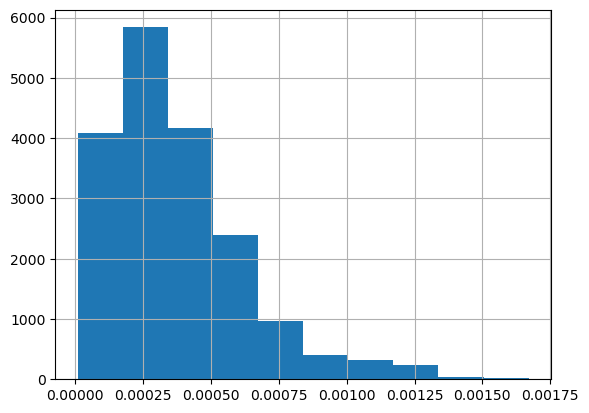

In [11]:
all_data.Infiltration.hist()
